## Setup

In [2]:
import sqlite3
# Create a connection to the database
db_connection = sqlite3.connect('../experiment.db')

# set info level logging
from logging import basicConfig, INFO, getLogger
basicConfig(level=INFO)
logger = getLogger(__name__)

import sys
import os

# Assuming the notebook is in the same directory as the 'custom' package
sys.path.append(os.path.abspath('..'))

## Plot results

/var/folders/l6/35dxxfx124zcvcvk2m6bcw240000gn/T/ipykernel_11405/255654788.py:102: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = df.pivot_table(


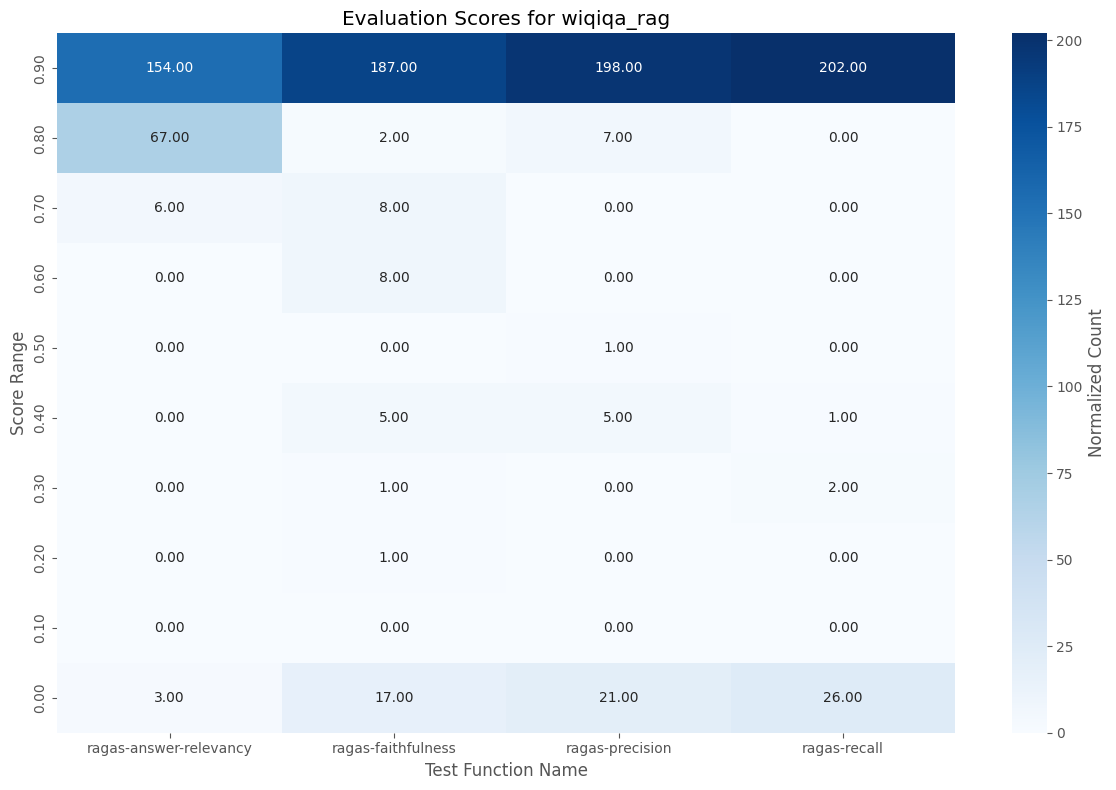

Summary Statistics:
                        count      mean       std  min       25%       50%  \
eval_function_name                                                           
ragas-answer-relevancy  230.0  0.900835  0.113467  0.0  0.889119  0.921719   
ragas-faithfulness      229.0  0.887918  0.278058  0.0  1.000000  1.000000   
ragas-precision         232.0  0.891882  0.293553  0.0  1.000000  1.000000   
ragas-recall            231.0  0.879509  0.321581  0.0  1.000000  1.000000   

                             75%       max  
eval_function_name                          
ragas-answer-relevancy  0.945813  0.991661  
ragas-faithfulness      1.000000  1.000000  
ragas-precision         1.000000  1.000000  
ragas-recall            1.000000  1.000000  


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

test_name = "wiqiqa_rag_gpt35turbo"

def get_data(conn):
    query = f"""
    SELECT 
        re.test_run_id,
        tr.description as test_run_name,
        re.question_id,
        q.question as question_content,
        re.response_id,
        r.response as response_content,
        re.test_eval_config_id,
        re.eval_score,
        ef.name as eval_function_name
    FROM response_evals re
    JOIN test_runs tr ON re.test_run_id = tr.id
    JOIN questions q ON re.question_id = q.id
    JOIN responses r ON re.response_id = r.id
    JOIN test_eval_configs tec ON re.test_eval_config_id = tec.id
    JOIN eval_functions ef ON tec.eval_function_id = ef.id
    WHERE tr.description = '{test_name}'
    """
    return pd.read_sql_query(query, conn)


def analyze_data(df):
    # Set the style for all plots
    plt.style.use('ggplot')

    # Heatmap of scores by test function
    # Create score bins
    decimal_precision = 2
    score_bins = np.round(np.linspace(0, 1, 11), decimal_precision)
    bin_labels = [f"{score:.{decimal_precision}f}" for score in score_bins[:-1]]

    df['score_bin'] = pd.cut(df['eval_score'], bins=score_bins, labels=bin_labels, include_lowest=True)

    # Create a pivot table
    pivot_data = df.pivot_table(
        values='eval_score', 
        index='score_bin', 
        columns='eval_function_name', 
        aggfunc='count',
        fill_value=0
    ).sort_index(ascending=False)

    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_data, cmap="Blues", annot=True, fmt='.2f', cbar_kws={'label': 'Normalized Count'})

    plt.title(f"Evaluation Scores for {test_name}")
    plt.xlabel("Test Function Name")
    plt.ylabel("Score Range")
    plt.tight_layout()
    plt.show()

    # 5. Summary statistics
    summary_stats = df.groupby('eval_function_name')['eval_score'].describe()
    summary_stats.to_csv('summary_statistics.csv')
    print("Summary Statistics:")
    print(summary_stats)

df = get_data(db_connection)
analyze_data(df)